In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


### The objective of this challenge is to forecast sticker sales in different countries. 

In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv")
test_df=pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv")
submission_df = pd.read_csv("/kaggle/input/playground-series-s5e1/sample_submission.csv")
train_df.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [3]:
print(f"The train dataset has",train_df.shape[0], "rows and", train_df.shape[1],"columns")

The train dataset has 230130 rows and 6 columns


In [4]:
# Understanding the data type of each variable
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [5]:
100*train_df.isnull().mean()

id          0.000000
date        0.000000
country     0.000000
store       0.000000
product     0.000000
num_sold    3.854778
dtype: float64

In [6]:
train_df['num_sold'].fillna(0,inplace=True)

In [7]:
100*train_df.isnull().mean()

id          0.0
date        0.0
country     0.0
store       0.0
product     0.0
num_sold    0.0
dtype: float64

In [8]:
# Feature engineering: Creating new variable to store day, month & yearr from date column 

# Converting date to Pandas datetime format
train_df['date'] = pd.to_datetime(train_df['date'])


train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year

# droping date column
train_df.drop('date',axis=1,inplace=True)

In [9]:
train_df.head()

,id,country,store,product,num_sold,day,month,year
0,0,Canada,Discount Stickers,Holographic Goose,0.0,1,1,2010
1,1,Canada,Discount Stickers,Kaggle,973.0,1,1,2010
2,2,Canada,Discount Stickers,Kaggle Tiers,906.0,1,1,2010
3,3,Canada,Discount Stickers,Kerneler,423.0,1,1,2010
4,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1,1,2010


### EDA

In [10]:
# Let's do descriptive analysis of the target variable- num_sold
train_df.num_sold.describe()

count    230130.000000
mean        723.519124
std         692.065736
min           0.000000
25%         184.000000
50%         575.000000
75%        1084.000000
max        5939.000000
Name: num_sold, dtype: float64

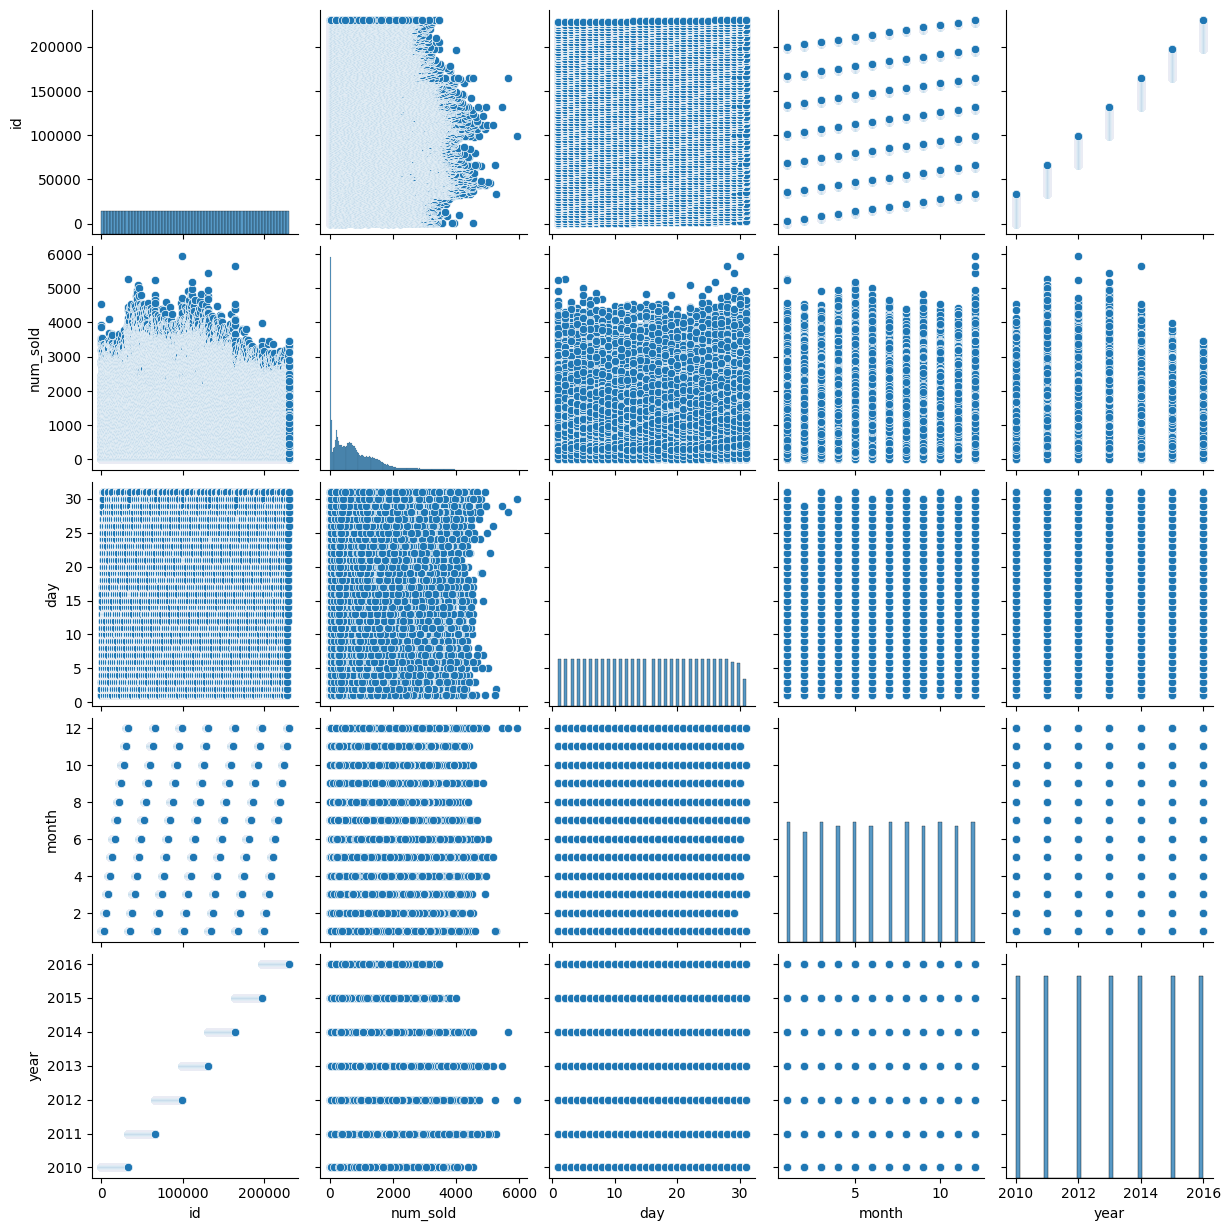

In [11]:
sns.pairplot(train_df)
plt.show()

In [12]:
train_df.store.value_counts()

store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64

In [13]:
train_df['product'].value_counts()

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64

In [14]:
train_df.country.value_counts()

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

### Data Pre-procesing

In [15]:
train_df["country"] = train_df["country"].map({"Canada":1,"Finland":2,"Italy":3, "Kenya":4,"Norway":5,"Singapore":6})
train_df["product"] = train_df["product"].map({"Holographic Goose":1, "Kaggle":2, "Kaggle Tiers":3, "Kerneler":4, "Kerneler Dark Mode":5})
train_df["store"] = train_df["store"].map({"Discount Stickers":1,"Stickers for Less":2, "Premium Sticker Mart":3})

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   country   230130 non-null  int64  
 2   store     230130 non-null  int64  
 3   product   230130 non-null  int64  
 4   num_sold  230130 non-null  float64
 5   day       230130 non-null  int32  
 6   month     230130 non-null  int32  
 7   year      230130 non-null  int32  
dtypes: float64(1), int32(3), int64(4)
memory usage: 11.4 MB


In [17]:
train_df.head()

,id,country,store,product,num_sold,day,month,year
0,0,1,1,1,0.0,1,1,2010
1,1,1,1,2,973.0,1,1,2010
2,2,1,1,3,906.0,1,1,2010
3,3,1,1,4,423.0,1,1,2010
4,4,1,1,5,491.0,1,1,2010


### Spliting Train & Test dataset

In [18]:
from sklearn.model_selection import train_test_split

np.random.seed(0)

df_train, df_test = train_test_split(train_df,train_size=0.7,random_state=100)


In [19]:
df_train.shape, df_test.shape

((161091, 8), (69039, 8))

In [20]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()

df_train['num_sold'] =scaler.fit_transform(df_train[['num_sold']])
df_test['num_sold'] =scaler.transform(df_test[['num_sold']])

In [21]:
df_train.num_sold.describe()

count    161091.000000
mean          0.121641
std           0.116558
min           0.000000
25%           0.030813
50%           0.096313
75%           0.182186
max           1.000000
Name: num_sold, dtype: float64

In [22]:
df_test.num_sold.describe()

count    69039.000000
mean         0.122254
std          0.116462
min          0.000000
25%          0.031487
50%          0.097660
75%          0.183196
max          0.918505
Name: num_sold, dtype: float64

In [23]:
y_train=df_train.pop("num_sold")
X_train = df_train

In [24]:
y_test = df_test.pop("num_sold")
X_test = df_test

In [25]:
y_train.shape, y_test.shape

((161091,), (69039,))

In [26]:
y_train.isnull().sum()

0

### Building Decision tree

In [27]:
from sklearn.tree import DecisionTreeRegressor 
dt=DecisionTreeRegressor()

In [28]:
from sklearn.model_selection import GridSearchCV

# parameters to tune
params = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for regression
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, 
                           n_jobs=-1, 
                           verbose=1, 
                           scoring="r2") 

In [29]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


GridSearchCV(cv=4, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2', verbose=1)

In [30]:
score_df =pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.228341,0.004206,0.008692,0.000533,3,1,2,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.607904,0.608306,0.613573,0.609593,0.609844,0.002241,19
1,0.219860,0.005730,0.005680,0.000096,3,1,5,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.607904,0.608306,0.613573,0.609593,0.609844,0.002241,19
2,0.219785,0.006384,0.005608,0.000163,3,1,10,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_s...",0.607904,0.608306,0.613573,0.609593,0.609844,0.002241,19
3,0.219023,0.004570,0.005589,0.000274,3,2,2,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.607904,0.608306,0.613573,0.609593,0.609844,0.002241,19
4,0.216057,0.001075,0.005851,0.000125,3,2,5,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_s...",0.607904,0.608306,0.613573,0.609593,0.609844,0.002241,27


In [31]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
18,0.427363,0.004489,0.008172,0.000289,7,1,2,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.944543,0.945821,0.945034,0.946087,0.945371,0.000616,1
20,0.431302,0.004614,0.008093,0.000392,7,1,10,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.944543,0.945821,0.945034,0.946087,0.945371,0.000615,2
21,0.431867,0.003179,0.007932,0.000378,7,2,2,"{'max_depth': 7, 'min_samples_leaf': 2, 'min_s...",0.944543,0.945821,0.945034,0.946087,0.945371,0.000615,3
26,0.415751,0.018665,0.006461,0.000829,7,4,10,"{'max_depth': 7, 'min_samples_leaf': 4, 'min_s...",0.944543,0.945821,0.945034,0.946087,0.945371,0.000616,4
19,0.424690,0.002003,0.008052,0.000532,7,1,5,"{'max_depth': 7, 'min_samples_leaf': 1, 'min_s...",0.944543,0.945789,0.945034,0.946087,0.945363,0.000610,5


In [32]:
grid_search.best_score_ # avg score for different folds

0.9453712493622901

In [33]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=7)

In [34]:
dt_best = grid_search.best_estimator_

In [35]:
from sklearn.metrics import r2_score,mean_squared_error,mean_squared_log_error

In [36]:
def evaluate_model(dt_classifier):
    y_train_pred = dt_classifier.predict(X_train)
    y_test_pred = dt_classifier.predict(X_test)
    print("Train set performance")
    print(r2_score(y_train, y_train_pred))
    print(mean_squared_error(y_train, y_train_pred))
    print(mean_squared_log_error(y_train, y_train_pred))
    print("*"*50)
    print("Test set performance")
    print(r2_score(y_test, y_test_pred)) 
    print(mean_squared_error(y_test, y_test_pred))
    print(mean_squared_log_error(y_test, y_test_pred))

In [37]:
evaluate_model(dt_best)

Train set performance
0.9455708799982911
0.0007394527917345603
0.00045101596201028695
**************************************************
Test set performance
0.9452078750664104
0.0007431534849782769
0.00045335149356275095


In [38]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz

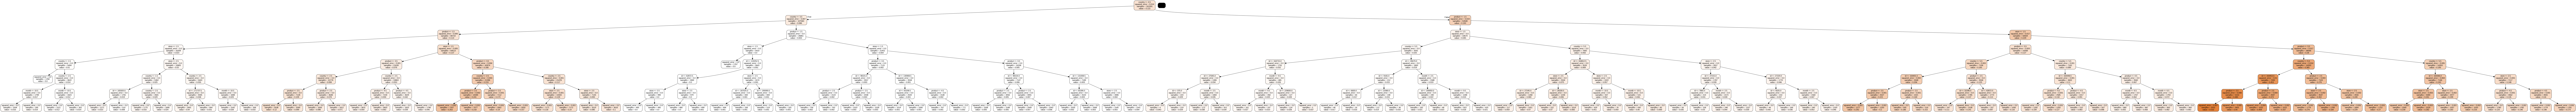

In [39]:
dot_data = StringIO()
export_graphviz(dt_best,out_file=dot_data, filled=True, rounded=True,
                feature_names=X_train.columns)
                #class_names=['No Disease','Disease'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Testin the model on test dataset.

In [40]:
test_df.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [41]:
test_df.shape

(98550, 5)

In [42]:
# Converting date to Pandas datetime format
test_df['date'] = pd.to_datetime(test_df['date'])


test_df['day'] = test_df['date'].dt.day
test_df['month'] = test_df['date'].dt.month
test_df['year'] = test_df['date'].dt.year

# droping date column
test_df.drop('date',axis=1,inplace=True)

In [43]:
test_df.head()

,id,country,store,product,day,month,year
0,230130,Canada,Discount Stickers,Holographic Goose,1,1,2017
1,230131,Canada,Discount Stickers,Kaggle,1,1,2017
2,230132,Canada,Discount Stickers,Kaggle Tiers,1,1,2017
3,230133,Canada,Discount Stickers,Kerneler,1,1,2017
4,230134,Canada,Discount Stickers,Kerneler Dark Mode,1,1,2017


In [44]:
# imputing numerical values to replace categorical values 

test_df["country"] = test_df["country"].map({"Canada":1,"Finland":2,"Italy":3, "Kenya":4,"Norway":5,"Singapore":6})
test_df["product"] = test_df["product"].map({"Holographic Goose":1, "Kaggle":2, "Kaggle Tiers":3, "Kerneler":4, "Kerneler Dark Mode":5})
test_df["store"] = test_df["store"].map({"Discount Stickers":1,"Stickers for Less":2, "Premium Sticker Mart":3})

In [45]:
test_df.head()

,id,country,store,product,day,month,year
0,230130,1,1,1,1,1,2017
1,230131,1,1,2,1,1,2017
2,230132,1,1,3,1,1,2017
3,230133,1,1,4,1,1,2017
4,230134,1,1,5,1,1,2017


In [46]:
predictions = dt_best.predict(test_df)

In [47]:
# Creating a DataFrame with 'id' and 'num_sold'
submission_df = pd.DataFrame({
    'id': test_df['id'],  
    'num_sold': predictions
})

# Saving the DataFrame as an .csv file
submission_df.to_csv('submission.csv', index=False)
print(submission_df.head())

       id  num_sold
0  230130  0.000000
1  230131  0.119625
2  230132  0.098932
3  230133  0.053974
4  230134  0.063092
